# Attempt at Moving Average Prediction/Polyfit #

**EXPLANATION FOR WHY WE'RE DOING WHAT WE'RE DOING PRIOR**:

The best model is going to be moving average prediction.

For context, weighted projections is opposite to moving average prediction. Weighted projections looks at macro changes and scales it down to micro, and moving average prediction scales from micro to macro.

This is what we hope to accomplish:
- If the smaller model is expanding, the total data should be expanding.
- Our dataset is small, but it can be divvied into different categories.
- If you're looking at total enrollment, we are breaking down into smaller subsets like F1 visas, programs, etc. so that way we can see if the previous semester has X enrollments we can look at the next semester's Y enrollments and identify changes.
- We would be not concerned with how dynamic these subsets are in a normal weighted projections.
- In the moving average predictions, we are looking at those dynamic predictions.

NumPY Polyfit regression has the highest possibility of fitting all of the data points because it can be linear or nonlinear, but only if we do regression for FALL and SPRING separately.

WE WILL ONLY BE USING INTERNATIONAL STUDENTS AND/OR NEW STUDENTS

We do NOT have a huge testing set, and it is better to completely overfit on the dataset rather than to underfit on 4 data points.

PROS AND CONS

PROS
- If our data is fluctuating, it will fit better
- If there's a cyclic change, it will fit better.
- It can analyze Spring and Fall better.
- These are fairly easy to train.

CONS
- For them to work better, you need a lot of datapoints to make sure you don't overfit on certain fluctuations.

In [482]:
import sqlite3
import pandas as pd
import os
from scipy.stats import boxcox
import copy
pd.options.mode.chained_assignment = None

In [483]:
import plotly.express as px

In [1]:
process_path = os.path.join(os.sep+"home"+os.sep+"jupyter"+os.sep+"Team-Prophecy","Data","02_processed","intermediate.db")
print(process_path)

NameError: name 'os' is not defined

In [485]:
process_connection = sqlite3.connect(process_path)

In [486]:
wait_stat = pd.DataFrame(process_connection.execute("""
    SELECT reg_term_code, reg_stu_id, crs, sect_id, reg_new_ret_stu, reg_final_status
    FROM registration_status rs
""").fetchall(),columns=["reg_term_code", "student_id", "crs", "sect_id", "returning_student", "reg_status"])

#WHERE reg_final_status IN ('W','R')
#GROUP BY reg_term_code, crs, sect_id, reg_final_status

student_details = pd.DataFrame(process_connection.execute("""
    SELECT stu_admit_term_code, stu_college, stu_deg_level, stu_dept, stu_id, stu_res, stu_prog, stu_visa, stu_bam
    FROM student_details 
""").fetchall(),columns=["reg_term_code","stu_college","stu_deg_level","stu_dept","student_id","stu_res","stu_prog","stu_visa","stu_bam"])
total_stat = wait_stat.merge(student_details, on=["reg_term_code","student_id"], how="inner").fillna(0)
total_stat = total_stat.loc[(total_stat["stu_visa"] == "F1 Visa") | (total_stat["returning_student"] == 'N')] #Likely will have to include required classes

#total_stat = total_stat.merge(dropped_stat, on=["reg_term_code", "crs", "sect_id"], how='left').fillna(0)
#total_stat.sort_values(by="Dropped",ascending=False).head()

In [487]:
#total_stat["crs_sect"] = total_stat["crs"]+"-"+total_stat["sect_id"]
#total_stat = total_stat.drop(["crs","sect_id"],axis=1)

There are likely two ways I can go with this. I can choose to either...
1) Find the course demand for individual courses (use crs_sect)
2) Find student interest their applied courses, and showing the classes they were waitlisted and registered for (use "student_id"

In [488]:
waitlist_df = total_stat.loc[total_stat["reg_status"] == 'W',["reg_term_code", "crs","sect_id", "reg_status"]].groupby(["reg_term_code", "crs","sect_id"]).count().reset_index()
reg_df = total_stat.loc[total_stat["reg_status"] == 'R',["reg_term_code", "crs","sect_id", "reg_status"]].groupby(["reg_term_code", "crs","sect_id"]).count().reset_index()
dropped_df = total_stat.loc[total_stat["reg_status"] == 'D',["reg_term_code", "crs","sect_id", "reg_status"]].groupby(["reg_term_code", "crs","sect_id"]).count().reset_index()

In [489]:
waitlist_df = waitlist_df.rename(columns={'reg_status':'waitlist'})
reg_df = reg_df.rename(columns={'reg_status':'registered'})
dropped_df = dropped_df.rename(columns={'reg_status':'dropped'})

In [490]:
total_df = reg_df.merge(waitlist_df, on=["reg_term_code", "crs","sect_id"], how="left").fillna(0)
total_df = total_df.merge(dropped_df, on=["reg_term_code", "crs","sect_id"], how="left").fillna(0)

In [491]:
total_df.head()

,reg_term_code,crs,sect_id,registered,waitlist,dropped
0,201770,AIT512,001,150,0.0,0.0
1,201770,AIT524,001,146,1.0,0.0
2,201770,AIT524,DL3,54,0.0,0.0
3,201770,AIT542,DL1,219,0.0,0.0
4,201770,AIT580,001,91,34.0,4.0


In [492]:
total_df["course_demand"] = total_df["registered"]+total_df["waitlist"]
total_df["demand_ratio"] = (total_df["course_demand"]-total_df["dropped"])/total_df["registered"]
total_df["demand_ratio"] = (total_df["demand_ratio"]-min(total_df["demand_ratio"]))/(max(total_df["demand_ratio"])-min(total_df["demand_ratio"]))
total_df = total_df[total_df["demand_ratio"] > 0]
total_df = total_df[total_df["demand_ratio"] < 1]
#total_df["demand_ratio"] = boxcox(total_df["demand_ratio"])
#total_df = total_df.loc[:,["reg_term_code","crs_sect","demand_ratio"]]

In [473]:
total_df.head()

,reg_term_code,crs,sect_id,registered,waitlist,dropped,course_demand,demand_ratio
0,201770,AIT512,001,150,0.0,0.0,150.0,0.567376
1,201770,AIT524,001,146,1.0,0.0,147.0,0.567473
2,201770,AIT524,DL3,54,0.0,0.0,54.0,0.567376
3,201770,AIT542,DL1,219,0.0,0.0,219.0,0.567376
4,201770,AIT580,001,91,34.0,4.0,125.0,0.572052


In [474]:
reg_term_code_list = total_df["reg_term_code"].unique().tolist()

In [475]:
total_df = total_df[["reg_term_code","crs","sect_id","demand_ratio"]]

IMPORTANT: This code is partially referenced from https://towardsdatascience.com/autocorrelation-for-time-series-analysis-86e68e631f77, and is used predominantly to determine autocorrelation. 

This is simply used here for us to better understand what is going on with our data.

__WHAT'S EFFECTIVELY HAPPENING HERE__

In this portion of the code, what we're doing is that we want to know if there are any major outliers for our data by performing autocorrelation.

Autocorrelation is used as a means to determine if one variable changes wildly per semester. In this instance, course demand as defined DOES NOT typically change throughout each semester by their course demand.

Course Demand is referenced as the total students that have dropped a course.

In [476]:
total_df_sample_ac = copy.deepcopy(total_df)
total_df_sample_ac["demand_ratio"] = 1+total_df_sample_ac["demand_ratio"]
#tdfgb = total_df.groupby("reg_term_code")
#grp_tdfgb = tdfgb.get_group("201770")
total_df_sample_ac["demand_boxcox"], lam = boxcox(total_df_sample_ac["demand_ratio"])
total_df_sample_ac.dropna(inplace=True)
#for r in reg_term_code_list:
#    tdfgb.get_group(r)["demand_ratio"] = boxcox(tdfgb.get_group(r)["demand_ratio"])

As seen, most of our values are pretty even keel for what we have regarding demand...

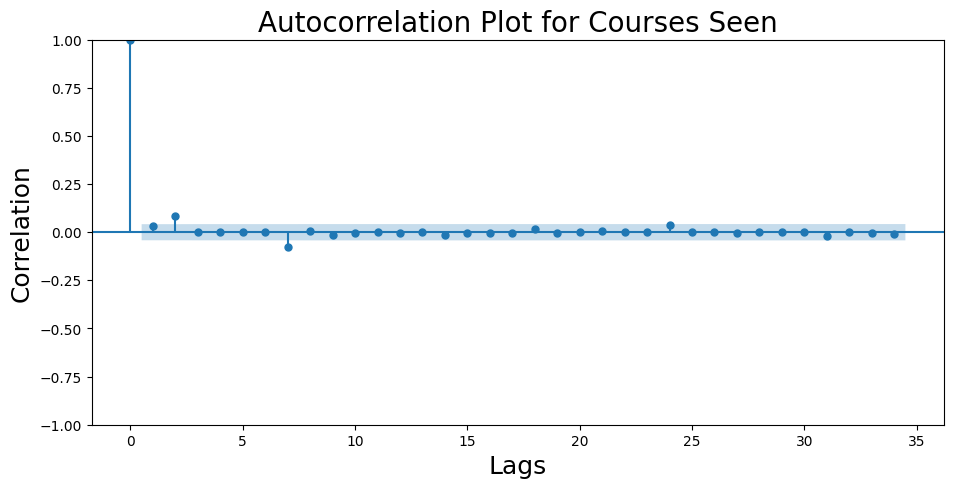

In [477]:
plot_acf(total_df_sample_ac['demand_boxcox'])
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.title('Autocorrelation Plot for Courses Seen', fontsize=20)
plt.show()

# Attempt at Linear Regression #

The primary goal of handling Linear Regression here is because we want to determine the primary predictors for these figures that we've placed together.

This is an OPTIONAL addendum that will take ALL fields gathered from the WebScrape, Professor, and Enrollment data and attempt to put them together to find the key predictors for high/low student course demand.

These fields will include...
- The Registration date
- The Student's College
- The Student's Department
- The Student's Program
- The Student's Residency
- The Student's BAM
- The Course's Name
- The Course's Section Number
- The Course's total number of credits

Students WILL be filtered by F1 VISA status and will only be applied if it is a CORE class

The INPUT consists of a table regarding these values.

The OUTPUT regards a confusion matrix as to the accuracy of these values.

In [478]:
total_df.head()

,reg_term_code,crs,sect_id,demand_ratio
0,201770,AIT512,001,0.567376
1,201770,AIT524,001,0.567473
2,201770,AIT524,DL3,0.567376
3,201770,AIT542,DL1,0.567376
4,201770,AIT580,001,0.572052


In [481]:
total_stat.head()

,reg_term_code,student_id,crs,sect_id,returning_student,reg_status,stu_college,stu_deg_level,stu_dept,stu_res,stu_prog,stu_visa,stu_bam
0,201770,CEC10171,SWE619,002,N,R,VSE,ms,CS,VA,VS-MS-SWE,Not Relevent,Not BAM
1,201770,CEC10171,SWE619,002,N,R,VSE,ms,CS,VA,VS-MS-SWE,Not Relevent,Not BAM
2,201770,CEC10171,SWE619,002,N,R,VSE,ms,CS,VA,VS-MS-SWE,Not Relevent,Not BAM
3,201770,CEC10171,SWE619,002,N,R,VSE,ms,CS,VA,VS-MS-SWE,Not Relevent,Not BAM
4,201770,CEC10171,SWE619,002,N,R,VSE,ms,CS,VA,VS-MS-SWE,Not Relevent,Not BAM


In [480]:
#total_stat[["reg_term_code","crs","sect_id","returning_student","reg_status","stu_"]].merge()

# Attempt at Random Forest #